In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.linalg as spla
import numpy.linalg as npla
import seaborn as sns
from itertools import groupby
from matplotlib.colors import LogNorm
import csv

In [2]:
from model_pvp import model_pvp
from generate_distribution import generate_distribution
from make_prob_matrix import make_prob_matrix
from get_fundamental_matrix import get_fundamental_matrix
from get_mean_time import get_mean_time
from get_border_cases import get_border_cases

In [3]:
from digitalize_states import digitalize_states
import get_games_strategy

In [69]:
N = 16

counts_pvp = np.load('../data/qr_counts_pvp.npy')
counts_pvp_400 = np.load('../data/qr_counts_pvp_400.npy')
counts_pve_border = np.load('../data/qr_counts_pve_border.npy')
counts_pve_center = np.load('../data/qr_counts_pve_center.npy')

qr_pve_border = np.load('../data/qr_pve_border.npy')
qr_pve_center = np.load('../data/qr_pve_center.npy')
qr_pvp = np.load('../data/qr_pvp.npy')
qr_pvp_400 = np.load('../data/qr_pvp_400.npy')

strategy_pve_center = np.load('../data/strategy_pve_center.npy')
strategy_pve_border = np.load('../data/strategy_pve_border.npy')
strategy_random = np.ones ((N + 1, N + 1), dtype=np.float64) * 0.5

strategy_pvp_border = np.load('../data/strategy_pvp_border.npy')
strategy_pvp_center = np.load('../data/strategy_pvp_center.npy')

strategy_pvp_400_border = np.load('../data/strategy_pvp_400_border.npy')
strategy_pvp_400_center = np.load('../data/strategy_pvp_400_center.npy')

strategy_pve_border_optimal = np.zeros ((N + 1, N + 1), dtype=np.float64)
strategy_pve_center_optimal = np.zeros ((N + 1, N + 1), dtype=np.float64)
strategy_pve_center_optimal = \
    np.diag(np.ones(N + 1) * 0.5) + \
    np.diag(np.ones(N), -1) + \
    np.diag(np.zeros(N), +1)
strategy_pve_center_optimal = strategy_pve_center_optimal.T

strategy_pve_center_optimal_2d = np.zeros ((N + 1, N + 1), dtype=np.float64)
strategy_pve_center_optimal_2d[1:N, 1] = 1
#strategy_pve_center_optimal_2d[:, N - 1] = 1
#strategy_pve_center_optimal_2d[1, :] = 1
strategy_pve_center_optimal_2d[N - 1, 1:N] = 1
strategy_pve_center_optimal_2d = strategy_pve_center_optimal_2d.T

qr_bvb, probabilities = make_prob_matrix(N, strategy_random, strategy_random)

qr_pve_border_pure, probabilities = make_prob_matrix(N, strategy_random, strategy_pve_border)
qr_pve_center_pure, probabilities = make_prob_matrix(N, strategy_pve_center, strategy_random)
qr_pvp_pure, probabilities = make_prob_matrix(N, strategy_pvp_center, strategy_pvp_border)
qr_pvp_400_pure, probabilities = make_prob_matrix(N, strategy_pvp_400_center, strategy_pvp_400_border)

qr_pve_border_optimal, probabilities = make_prob_matrix(N, strategy_random, strategy_pve_border_optimal)
qr_pve_center_optimal, probabilities = make_prob_matrix(N, strategy_pve_center_optimal, strategy_random)
qr_pve_center_optimal_2d, probabilities = make_prob_matrix(N, strategy_pve_center_optimal_2d, strategy_random)

In [70]:
def qr_to_probabilities(qr, N):
    frequencies = qr.copy()
    border = get_border_cases(N)
    for i in np.arange(len(border)-1, -1, step = -1):
        frequencies = np.delete(frequencies, border[i], axis = 0)
        frequencies = np.delete(frequencies, border[i], axis = 1)
    return frequencies

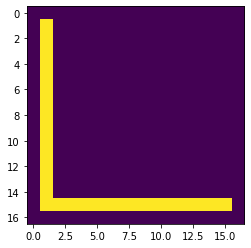

In [71]:
plt.imshow(strategy_pve_center_optimal_2d.T)

In [72]:
x, y = 8, 9
qr_pve_center_optimal[(N+1) * x + y, (N+1) * (x - 0) + (y + 1)]

0.0

In [73]:
qrs = {
    'pve_border': qr_pve_border,
    'pve_center': qr_pve_center,
    'bvb': qr_bvb,
    'pve_border_pure': qr_pve_border_pure,
    'pve_center_pure': qr_pve_center_pure,
    'pvp': qr_pvp,
    'pvp_pure': qr_pvp_pure,
    'pvp_400': qr_pvp_400,
    'pvp_400_pure': qr_pvp_400_pure,
    'pve_border_optimal': qr_pve_border_optimal,
    'pve_center_optimal': qr_pve_center_optimal,
    'pve_center_optimal_2d': qr_pve_center_optimal_2d,
}

In [74]:
def remove_absorption_states(qr, N):
    new_matrix = qr.copy()
    border_states = get_border_cases(N)
    
    new_matrix = np.delete(new_matrix, border_states, axis=0)
    new_matrix = np.delete(new_matrix, border_states, axis=1)
    
    return new_matrix

In [75]:
def get_max_eigenvectors_h(qr):
    e_values, e_vec_r = npla.eigh(qr) 
    
    max_ev_index = np.where(np.isclose(abs(e_values), abs(max(e_values, key=abs))))[0][0]
    
    max_right_vec = e_vec_r[:, max_ev_index]
    
    return e_values, e_vec_r, max_right_vec, max_ev_index

In [241]:
def get_max_eigenvectors(qr):
    e_values, e_vec_l, e_vec_r = spla.eig(qr, left=True, right=True) 
    
    indices = range(0, len(e_values))
    e_values, indices = zip(*sorted(zip(e_values, indices), reverse=True))
    
    indices = list(indices)
    
    max_left_vec_positive = e_vec_l[:, indices[0]]
    max_right_vec_positive = e_vec_r[:, indices[0]]
    
    max_left_vec_negative = e_vec_l[:, indices[-1]]
    max_right_vec_negative = e_vec_r[:, indices[-1]]
    
    return e_values, max_left_vec_positive, max_right_vec_positive, max_left_vec_negative, max_right_vec_negative

In [320]:
def visualise_eigenvalues(e_values, case):
    plt.clf()
    unique_e_vals, counts = np.unique(e_values, return_counts=True)
    
    fig, ax = plt.subplots(1, figsize=(16,9), dpi=300)
        
    xs_for_axis = unique_e_vals
    ys_for_axis = np.zeros(shape=(len(xs_for_axis)))
        
    ax.set_title("Eigenvalues")
    ax.set_xlabel("Eigenvalue")
    ax.set_ylabel("Eigenvalue multiplicity")
    ax.plot(xs_for_axis, ys_for_axis, marker='x')
    
    for i in range(len(unique_e_vals)):
        x = unique_e_vals[i]
        y_max = counts[i]
        
        ys = np.arange(start=0, stop=y_max, step=0.01)
        xs = [x] * len(ys)
        ax.plot(xs, ys)
        
    fig.savefig("../Eigenvectors/" + case + '/' + "eigenvalues.png", transparent=False, \
                facecolor='white', edgecolor='white')
    
    return unique_e_vals, counts

In [321]:
def visualise_eigenvector(vector, N, case, lr):    
    plt.clf()
    
    plt.rcParams['figure.dpi'] = 300
    plt.title("Eigenvector " + lr)
    
    grid = np.zeros(shape=(N, N))
    for i in range(N):
        for j in range(N):
            grid[i, j] = vector[i * N + j]
            
    plt.xlim((-0.5, N-0.5))
    plt.ylim((-0.5, N-0.5))
    plt.imshow(grid)
    plt.colorbar()
    
    plt.savefig("../Eigenvectors/" + case + '/' + "eigenvector_" + lr + ".png", transparent=False, \
                facecolor='white', edgecolor='white')

In [322]:
from pathlib import Path
def make_directory(case):
    p = Path("../Eigenvectors/" + case + '/')
    p.mkdir(parents=True, exist_ok=True)

In [323]:
import csv
def save_evalues(unique_evals, counts, case, vl_pos, vr_pos, vl_neg, vr_neg):
    
    unique_evals = np.real(unique_evals)
    
    unique_evals, counts = zip(*sorted(zip(unique_evals, counts), reverse=True))
        
    unique_evals = list(unique_evals)
    counts=  list(counts)
    path = '../Eigenvectors/' + case + '/' + 'values.tsv'

    
    with open(path, 'w') as out_file:
        tsv_writer = csv.writer(out_file, delimiter='\t')
        out_file.write('lambdas\n')
        
        [out_file.write('{:.5f} '.format(x)) for x in unique_evals]
        out_file.write('\n')
        [out_file.write('{0:7d} '.format(c)) for c in counts]
        out_file.write('\n')
        
        out_file.write('max left eigenvector for positive lambda\n')
        tsv_writer.writerow(vl_pos)
        out_file.write("max right eigenvector for positive lambda\n")
        tsv_writer.writerow(vr_pos)

        out_file.write("max left eigenvector for negative lambda\n")
        tsv_writer.writerow(vl_neg)
        out_file.write("max right eigenvector for negative lambda\n")
        tsv_writer.writerow(vr_neg)

G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casti

C:\Users\serge\AppData\Local\Temp/ipykernel_22236/1228464707.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting compl

C:\Users\serge\AppData\Local\Temp/ipykernel_22236/1228464707.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting compl

C:\Users\serge\AppData\Local\Temp/ipykernel_22236/1228464707.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting compl

C:\Users\serge\AppData\Local\Temp/ipykernel_22236/1228464707.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting compl

C:\Users\serge\AppData\Local\Temp/ipykernel_22236/1228464707.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting compl

C:\Users\serge\AppData\Local\Temp/ipykernel_22236/1228464707.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting compl

C:\Users\serge\AppData\Local\Temp/ipykernel_22236/1228464707.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting compl

C:\Users\serge\AppData\Local\Temp/ipykernel_22236/1228464707.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting compl

C:\Users\serge\AppData\Local\Temp/ipykernel_22236/1228464707.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting compl

C:\Users\serge\AppData\Local\Temp/ipykernel_22236/1228464707.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting compl

C:\Users\serge\AppData\Local\Temp/ipykernel_22236/1228464707.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  grid[i, j] = vector[i * N + j]


<Figure size 432x288 with 0 Axes>

<Figure size 4800x2700 with 0 Axes>

<Figure size 4800x2700 with 0 Axes>

<Figure size 4800x2700 with 0 Axes>

<Figure size 4800x2700 with 0 Axes>

<Figure size 4800x2700 with 0 Axes>

<Figure size 4800x2700 with 0 Axes>

<Figure size 4800x2700 with 0 Axes>

<Figure size 4800x2700 with 0 Axes>

<Figure size 4800x2700 with 0 Axes>

<Figure size 4800x2700 with 0 Axes>

<Figure size 4800x2700 with 0 Axes>

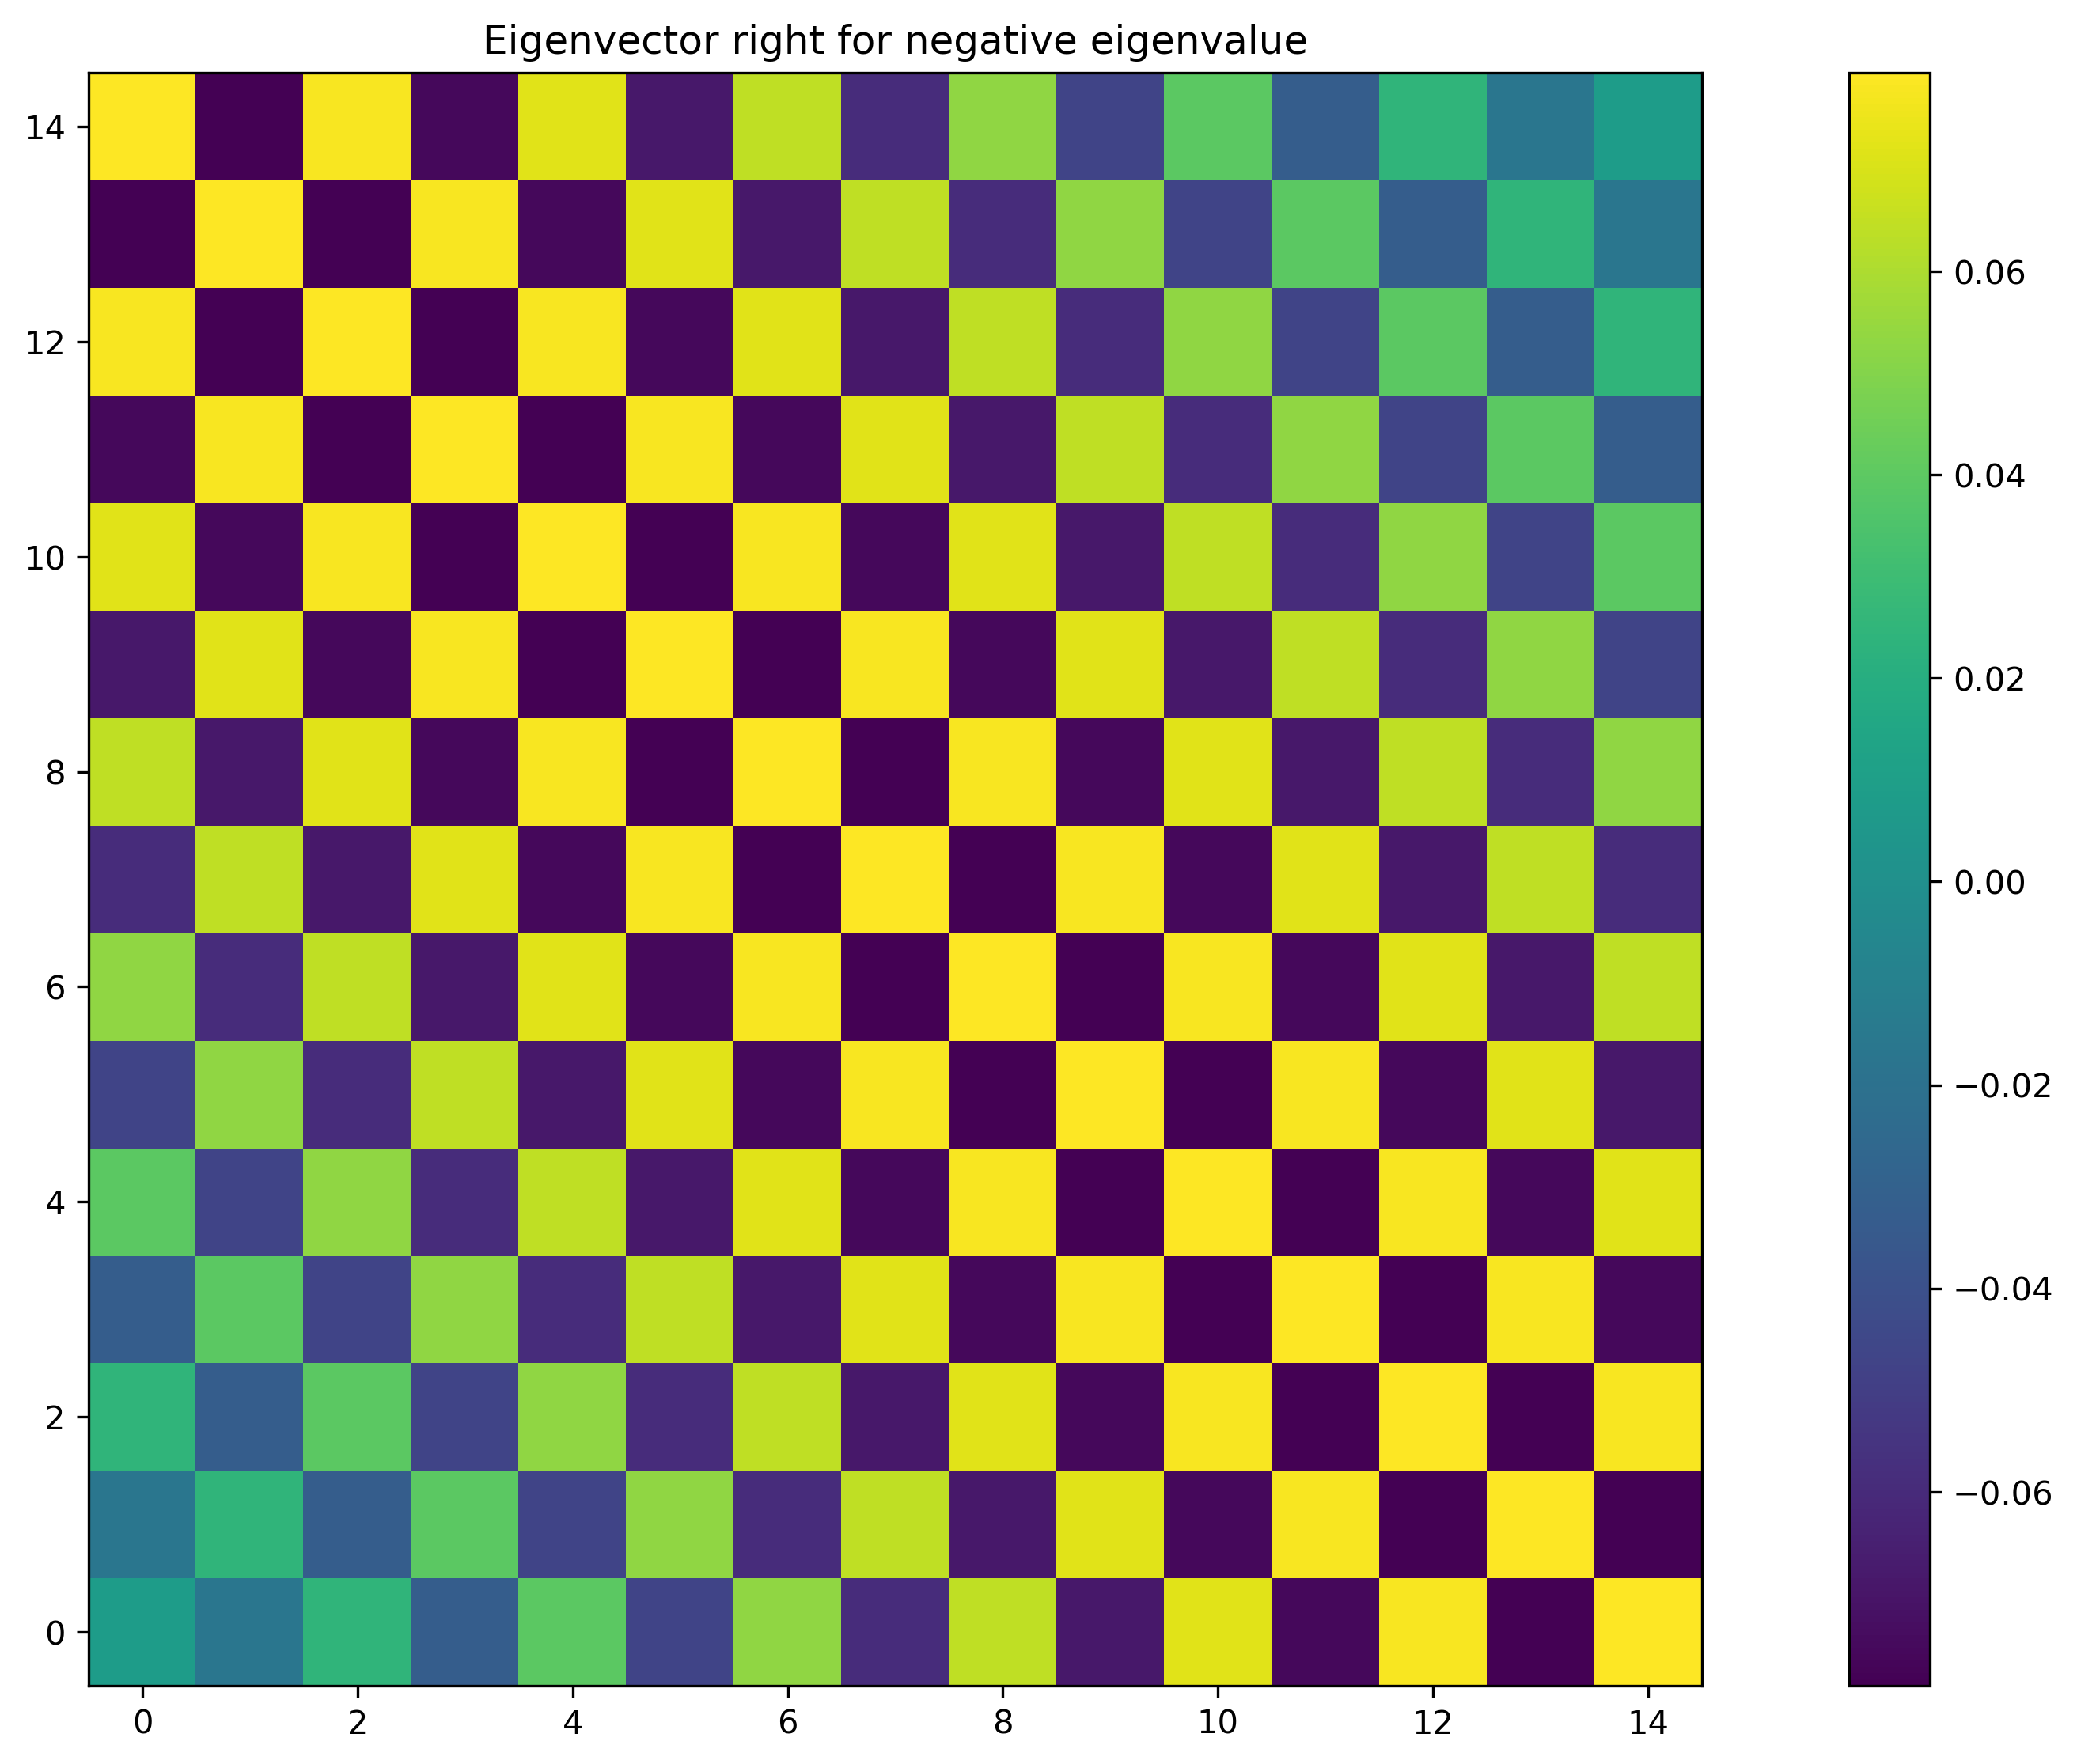

In [324]:
for qr in qrs:
    
    make_directory(qr)
    matrix = qrs[qr]
    mx = remove_absorption_states(matrix, N)

    e_values, vl_pos, vr_pos, vl_neg, vr_neg = get_max_eigenvectors(mx)
    
    unique_evals, counts = visualise_eigenvalues(e_values, qr)
    
    visualise_eigenvector(-vl_pos, N - 1, qr, 'left for positive eigenvalue')
    visualise_eigenvector(-vr_pos, N - 1, qr, 'right for positive eigenvalue')
    visualise_eigenvector(vl_neg, N - 1, qr, 'left for negative eigenvalue')
    visualise_eigenvector(vr_neg, N - 1, qr, 'right for negative eigenvalue')
    
    save_evalues(unique_evals, counts, qr, np.real(vl_pos), np.real(vr_pos), np.real(vl_neg), np.real(vr_neg))